<center><h1 style="text-align: center;"><u>TFM - Detección temprana del cáncer a partir de los resultados de análisis de sangre</u></h1>
<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

# INTRODUCCIÓN

En este notebook se lleva a cabo el contraste del modelo CancerA1DE para la detección prematura de cáncer frente a otros modelos de predicción.

El artículo sobre el que se basa esta investigación es "Early Cancer Detection from Multianalyte Blood Test Results" presente en : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6548890/

El contenido abarca un repaso de los datos, su análisis a todos los niveles y los diferentes enfoques para entrenar, validar y testear los distintos modelos.

Los datos se encontrarán en la siguiente ruta en local : C:\Users\danie\OneDrive\Documentos\Master\Lusku\TFM\Proposiciones\Deteccion Cancer\Datos

IMPORTANTE : Cada vez que tenga que rellenarse a mano el valor de una variable, se mostrará con : 

                    (I) Introducir valor de 'nombreDeLaVariable'

Para descargar las librerías usadas en este proyecto se puede hacer usar el comando "pip install -r requirements.txt" en el terminal

Los bloques de código que empiezan por # P , forman parte del proceso principal y son necesarios ejecutarse para seguir el flujo del proceso.

In [3]:
# P
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import normaltest

# Entrenar el modelo
from sklearn.model_selection import train_test_split

# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_classif

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, r2_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


# Funciones

In [4]:
# Functions

# Conversion del dataFrame a tipo numeric
def convert_to_numeric(column):
    if column.dtype in ['object','category']:
        # Verificar si hay letras en todos los registros
        contains_letters = any(isinstance(val, str) and any(c.isalpha() for c in val) for val in column)
        if not contains_letters :
            return pd.to_numeric(column, errors='coerce')
    return column

def discretizar_df_arboles_1(df, max_depth=40, n_bins=18, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc' or columna.name == 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado.apply(convert_to_numeric)

# Discretizar dataFrame y mostrar correlación respecto a la variable objetivo
def discretizar_df_arboles(df, imprimir="SI", max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc' or columna.name != 'Tumor type': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
   # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas = df_discretizado.corrwith(df_discretizado['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

    if imprimir == "SI":
        # Imprimir las top 20 correlaciones
        print(top_20_correlaciones_discretas)

    return df_discretizado


def escalado_dataFrame(df) :
    if df.empty:
        raise ValueError("El DataFrame está vacío, no se puede realizar el escalado.")

    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Normalizar df_imputacion_iterativa
    df_normalized = df.select_dtypes(include=['number']).copy()  # Crear una copia del DataFrame original
    
    if not df_normalized.empty:
        df_normalized[df_normalized.columns] = scaler.fit_transform(df_normalized)
    else :
        print("Esto está vacío")
    return df_normalized

def calcular_ganancia_informacion(df_features, target, imprimir = 'SI'):
    
    # Extraer las características de interés del DataFrame
    X_interest = df_features.values
    
    # Extraer la variable objetivo del DataFrame principal
    y = target.values
    
    # Calcular la Ganancia de Información utilizando Mutual Information
    information_gain = mutual_info_classif(X_interest, y, discrete_features=False, random_state=42, n_neighbors=7)
    
    # Crear un DataFrame para visualizar los resultados
    ig_results = pd.DataFrame({'Feature': df_features.columns, 'Information Gain': information_gain})
    
    # Ordenar los resultados por Ganancia de Información en orden descendente
    ig_results_sorted = ig_results.sort_values(by='Information Gain', ascending=False)

    if imprimir == "SI":
        print(ig_results_sorted)

# División del conjunto de datos en entrenamiento, validacion y test 


def split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=None):
    """
    Divide un conjunto de datos en entrenamiento, validación y test.

    Args:
        X: Matriz de características.
        y: Vector de etiquetas.
        train_size: Porcentaje de datos para entrenamiento (por defecto: 0.6).
        val_size: Porcentaje de datos para validación (por defecto: 0.2).
        test_size: Porcentaje de datos para test (por defecto: 0.2).
        random_state: Semilla para la aleatorización (por defecto: None).

    Returns:
        Tuple: (X_train, X_val, X_test, y_train, y_val, y_test).
    """
    assert train_size + val_size + test_size == 1.0, "La suma de train_size, val_size y test_size debe ser igual a 1.0"

    # Dividir los datos en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Calcular porcentaje respecto al tamaño original
    val_size_relative = val_size / (1.0 - test_size)

    # Dividir los datos de entrenamiento en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_relative, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def mostrar_cross_validation(model, X_train, y_train):
    cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )
    print("Cross validation : ")
    print(f"Métricas validación cruzada: {cv_scores}")
    print(f"Média métricas de validación cruzada: {cv_scores.mean()}")
    print("")

def mostrar_score(X_train, y_train, model):
    score = round(model.score(X_train, y_train), 3)*100
    print(f"Tanto por ciento de acierto : {score} %")
    print("")

def mostrar_estadisticas(y_val, y_pred) :
    mse = round(mean_squared_error(y_val, y_pred),3)
    accuracy = round(accuracy_score(y_val, y_pred),3)
    precision = round(precision_score(y_val, y_pred),3)
    recall = round(recall_score(y_val, y_pred),3)
    f1 = round(f1_score(y_val, y_pred),3)
    conf_matrix = confusion_matrix(y_val, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Error cuadrático medio en el conjunto de validación:", mse)
    print("Matriz de Confusión :\n", conf_matrix)
    print("")

def mostrar_curva_ROC(y_val, y_pred) :
    fpr, tpr, _ = roc_curve(y_val, y_pred)

    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Plotear la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"Metrics for {set_name} set:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Función para mostrar métricas y añadirlas a un DataFrame
def mostrar_estadisticas_guardar_tabla(y_val, y_pred, set_name, model_name, print_roc = 'NO'):
    '''
    Ejemplo de uso :

    # Fase de entrenamiento
    results_df = mostrar_estadisticas_guardar_tabla(y_train, kmeans.predict(X_train_prep), "Training", results_df, model_name)

    # Fase de validación
    results_df = mostrar_estadisticas_guardar_tabla(y_val, kmeans.predict(X_val_prep), "Validation", results_df, model_name)

    # Fase de prueba
    results_df = mostrar_estadisticas_guardar_tabla(y_test, kmeans.predict(X_test_prep), "Test", results_df, model_name)

    # Importante: Al final de todos los modelos (fuera del método): Guardar los resultados en un archivo Excel
    results_df.to_excel('model_results.xlsx', index=False)

    '''
    global tabla_results_df
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    rand_index = adjusted_rand_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    if conf_matrix.shape == (2, 2):  # Asegúrate de que es una matriz de confusión 2x2
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        tn = fp = fn = tp = None  # Si no es una matriz 2x2, asigna valores None
    
    global_score = calcular_puntuacion_global(accuracy, precision, recall, f1, rand_index, r2, mse, tn, fp, fn, tp, roc_auc)
    
    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set :")
    print(f" - Accuracy: {accuracy:.4f}")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall: {recall:.4f}")
    print(f" - F1-Score: {f1:.4f}")
    print(f" - Adjusted Rand Index: {rand_index:.4f}")
    print(f" - Mean Squared Error: {mse:.4f}")
    print(f" - R-squared: {r2:.4f}")
    print(f" - Área bajo la curva : {roc_auc:.3f}")
    print(f" - Confusion Matrix: \n{conf_matrix}")
    #if tn is not None and fp is not None and fn is not None and tp is not None:
    #   print(f"\tTN: {tn}\n\tFP: {fp}\n\tFN: {fn}\n\tTP: {tp}")
    print(f" - Global Score : {global_score}")
    print(f"")
    
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Set': [set_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-Score': [f1],
        'Adjusted Rand Index': [rand_index],
        'Mean Squared Error': [mse],
        'R-squared': [r2],
        'AUC-ROC': [roc_auc],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'TP': [tp],
        'Global Score' : [global_score]
    })

    if (print_roc == 'SI') :
        plot_ROC(fpr, tpr, roc_auc)
    
    tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)
    
    return tabla_results_df

def plot_ROC(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

def calcular_puntuacion_global(accuracy, precision, recall, f1, rand_index, r2, mse, tn, fp, fn, tp, auc_roc):
    # Definir ponderaciones para cada métrica
    weights = {
        'accuracy': 0.12,
        'precision': 0.12,
        'recall': 0.12,
        'f1': 0.12,
        'rand_index': 0.1,
        'r2': 0.05,
        'mse': 0.05,
        'tpr': 0.1,
        'fpr': 0.1,
        'auc_roc': 0.12,
    }
    
    # Normalizar las métricas
    mse_norm = (1 - mse)  # Invertir MSE ya que menor es mejor
    r2_norm = (r2 + 1) / 2  # Normalizar R2 para que esté entre 0 y 1
    tpr_norm = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr_norm = fp / (fp + tn) if (fp + tn) != 0 else 0
    
    # Calcular la puntuación global
    global_score = (accuracy * weights['accuracy'] +
                    precision * weights['precision'] +
                    recall * weights['recall'] +
                    f1 * weights['f1'] +
                    rand_index * weights['rand_index'] +
                    r2_norm * weights['r2'] +
                    mse_norm * weights['mse'] +
                    tpr_norm * weights['tpr'] +
                    (1 - fpr_norm) * weights['fpr'] +
                    auc_roc * weights['auc_roc'])  # Invertir FPR ya que menor es mejor
    
    return round(global_score * 100, 2)

# Funciones para aprendizaje no supervisado
def optimal_cluster_number(X_train, X_val, model, max_clusters=10, method='elbow', plot_grafica = 'NO'):
    """
    Encuentra el número óptimo de clusters para un modelo de clustering utilizando el método del codo (Elbow Method)
    u otros métodos.
    """
    if method == 'elbow':
        distortions = []
        for i in range(1, max_clusters + 1):
            model.n_clusters = i
            model.fit(X_train)
            distortions.append(model.inertia_)
        if plot_grafica == 'SI':
            # Plotting the elbow curve
            plt.plot(range(1, len(distortions) + 1), distortions, marker='o')
            plt.xlabel('Número de clusters')
            plt.ylabel('Distorsión')
            plt.title('Método del codo para encontrar el número óptimo de clusters')
            plt.show()

        # Finding the optimal number of clusters based on the elbow point
        optimal_k = np.argmin(np.gradient(distortions)) + 1
        if optimal_k == 1:  # Ensure that the optimal number of clusters is greater than 1
            optimal_k = 2
        return optimal_k

    elif method == 'silhouette':
        silhouette_scores = []
        for i in range(2, max_clusters + 1):
            model.n_clusters = i
            model.fit(X_train)
            labels = model.predict(X_val)
            silhouette_scores.append(silhouette_score(X_val, labels))
        
        if plot_grafica == 'SI':
            # Plotting the silhouette scores
            plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
            plt.xlabel('Número de clusters')
            plt.ylabel('Silhouette Score')
            plt.title('Silhouette Score para encontrar el número óptimo de clusters')
            plt.show()

        # Finding the optimal number of clusters based on silhouette score
        optimal_k = np.argmax(silhouette_scores) + 2
        return optimal_k

    else:
        raise ValueError("Método no válido. Métodos disponibles: 'elbow', 'silhouette', etc.")


# Función para motrar estadísticas para modelos de aprendizaje no supervisado   
def mostrar_estadisticas_guardar_tabla_NS(X, labels, set_name, model_name):
    '''
    Ejemplo de uso :

    # Fase de entrenamiento
    results_df = mostrar_estadisticas_guardar_tabla(X_train, kmeans.predict(X_train), "Training", model_name, results_df)

    # Fase de validación
    results_df = mostrar_estadisticas_guardar_tabla(X_val, kmeans.predict(X_val), "Validation", model_name, results_df)

    # Fase de prueba
    results_df = mostrar_estadisticas_guardar_tabla(X_test, kmeans.predict(X_test), "Test", model_name, results_df)

    # Importante: Al final de todos los modelos (fuera del método): Guardar los resultados en un archivo Excel
    results_df.to_excel('model_results.xlsx', index=False)
    '''
    global tabla_results_NS_df
    silhouette_avg = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    global_score = calcular_puntuacion_global_NS(silhouette_avg, db_score, ch_score)
    
    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set ({model_name}):")
    print(f" - Silhouette Score: {silhouette_avg:.4f}")
    print(f" - Davies-Bouldin Index: {db_score:.4f}")
    print(f" - Calinski-Harabasz Index: {ch_score:.4f}")
    print(f" - Global Score: {global_score:.4f}")
    print(f"")
    
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Set': [set_name],
        'Silhouette Score': [silhouette_avg],
        'Davies-Bouldin Index': [db_score],
        'Calinski-Harabasz Index': [ch_score],
        'Global Score': [global_score]
    })
    
    tabla_results_NS_df = pd.concat([tabla_results_NS_df, new_row], ignore_index=True)
    
    return tabla_results_NS_df

def calcular_puntuacion_global_NS(silhouette_avg, db_score, ch_score):
    # Normalizando los valores para que estén en el rango de 0 a 100
    normalized_silhouette = (silhouette_avg + 1) * 50  # Ajustando el rango del Silhouette Score de -1 a 1 a 0 a 100
    normalized_davies_bouldin = (1 - db_score) * 50  # Ajustando el rango del Davies-Bouldin Index de 0 a 1 a 0 a 100

    # Calculando el puntaje global promediando los puntajes normalizados
    global_score = (normalized_silhouette + normalized_davies_bouldin + ch_score) / 3

    return global_score

def show_save_results_no_supervised(X, labels, set_name, model_name):
    global tabla_results_NS_df
    silhouette_avg = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    global_score = calcular_global_score(silhouette_avg, db_score, ch_score)

    # Imprimir todas las métricas
    print(f"Metrics for {set_name} set ({model_name}):")
    print(f" - Silhouette Score: {silhouette_avg:.4f}")
    print(f" - Davies-Bouldin Index: {db_score:.4f}")
    print(f" - Calinski-Harabasz Index: {ch_score:.4f}")
    print(f" - Global Score: {global_score:.4f}")
    print(f"")

    new_row = pd.DataFrame({
            'Model': [model_name],
            'Set': [set_name],
            'Silhouette Score': [silhouette_avg],
            'Davies-Bouldin Index': [db_score],
            'Calinski-Harabasz Index': [ch_score],
            'Global Score': [global_score]
        })
        
    tabla_results_NS_df = pd.concat([tabla_results_NS_df, new_row], ignore_index=True)
        
    return tabla_results_NS_df

def calcular_global_score(silhouette_score, davies_bouldin_index, calinski_harabasz_index):
    # Normalizar los valores para que estén en el rango de 0 a 100
    normalized_silhouette = (silhouette_score + 1) * 50  # Ajustando el rango del Silhouette Score de -1 a 1 a 0 a 100
    normalized_davies_bouldin = (1 - davies_bouldin_index) * 100  # Ajustando el rango del Davies-Bouldin Index de 0 a 1 a 0 a 100

    # Calculando el puntaje global promediando los puntajes normalizados
    global_score = (normalized_silhouette + normalized_davies_bouldin + calinski_harabasz_index) / 3

    return global_score

def encontrar_numero_optimo_clusters(X_train, X_val, model, max_clusters=10, plot_grafica = 'NO'):
    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    global_scores = []

    for i in range(2, max_clusters+1):
        model.n_clusters = i
        model.fit(X_train)

        # Predecir las etiquetas para los datos de validación
        labels = model.predict(X_val)

        # Calcular las métricas
        silhouette = silhouette_score(X_val, labels)
        davies_bouldin = davies_bouldin_score(X_val, labels)
        calinski_harabasz = calinski_harabasz_score(X_val, labels)
        
        global_score = calcular_global_score(silhouette, davies_bouldin, calinski_harabasz)
        
        wcss.append(model.inertia_)
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        calinski_harabasz_scores.append(calinski_harabasz)
        global_scores.append(global_score)

    if plot_grafica == 'SI':
        # Plot para el método del codo
        plt.figure(figsize=(12, 8))
        plt.plot(range(2, max_clusters+1), wcss, marker='o')
        plt.title('Método del Codo')
        plt.xlabel('Número de Clústeres')
        plt.ylabel('WCSS')
        plt.show()

        # Plot para las métricas de validación
        plt.figure(figsize=(12, 8))
        plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o', label='Silhouette Score')
        plt.plot(range(2, max_clusters+1), davies_bouldin_scores, marker='o', label='Davies-Bouldin Index')
        plt.plot(range(2, max_clusters+1), calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Index')
        plt.plot(range(2, max_clusters+1), global_scores, marker='o', label='Global Score')
        plt.title('Métricas de Validación para Diferentes Números de Clústeres')
        plt.xlabel('Número de Clústeres')
        plt.ylabel('Valor de la Métrica')
        plt.legend()
        plt.show()

    # Encontrar el número óptimo de clústeres basado en el puntaje global
    numero_optimo_clusters = range(2, max_clusters+1)[np.argmax(global_scores)]
    return numero_optimo_clusters


# Procesamiento de datos

In [5]:
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Proposiciones/Deteccion Cancer/Datos/{nombreArchivo}.xlsx'

# Se procede a hacer una carga de los datos. 
df_original= pd.read_excel(url_datos, sheet_name='Table S6')

# Crear una copia del DataFrame original para realizar los cambios
df6 = df_original.copy()

# Recorrer las columnas del DataFrame para eliminar las cadenas de texto : ['*', '**']
for columna in df6.columns:
    if df6[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in ['*', '**']:
            df6[columna] = df6[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

df_prep = df6.apply(convert_to_numeric)

# Relleno de nulos de la variable "AJCC Stage"
df_prep["AJCC Stage"] = df_prep["AJCC Stage"].fillna("0")

# Calcular la media solo para las columnas numéricas
numeric_columns = df_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df = df_prep.copy()  # Copiar el DataFrame preprocesado para evitar modificarlo
for col in mean_values.index:
    df[col].fillna(mean_values[col], inplace=True)


# Binarización "Tumor Type" 0 -> NO CANCER; 1 -> SI CANCER + 'CancerSEEK Test Result'
df['Tumor type'] = df['Tumor type'].apply(lambda x: 0 if str(x).strip().lower() == "normal" else 1).astype(int)
#df['CancerSEEK Test Result'] = df['CancerSEEK Test Result'].apply(lambda x: 0 if str(x).strip().lower() == "negative" else 1).astype(int)

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['Tumor type','CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']

## --- CHECKPOINT ----- Datos limpios

# Columna objetivo
Y_column = df['Tumor type'].copy()
# Reducción del dataFrame
df_reduced = df[columnas_a_conservar].copy()
#Copia del dataFrame entero
df_full = df.copy()

''' INICIO - Verificacion del information gain'''
# Information Gain inicial
df_discretizado = discretizar_df_arboles_1(df_reduced.drop(columns=['Tumor type']))
df_reduced_discretizado_escalated = escalado_dataFrame(df_discretizado)
calcular_ganancia_informacion(df_reduced_discretizado_escalated, Y_column, imprimir = "NO")

# Information Gain usando arboles de decision (acorde a : "..the cancer antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the purity and accuracy measurements..")
df_discretizado_full = discretizar_df_arboles(df_full, imprimir ="NO") # Columnas de este segundo enfoque guardadas en columnas_segundo_enfoque
df_discretizado_reduced = discretizar_df_arboles(df_reduced,imprimir ="NO")

''' FIN - Verificacion del information gain'''

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE SUPERVISADO
tabla_results_df = pd.DataFrame(columns=['Model', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Adjusted Rand Index', 'Mean Squared Error', 'R-squared','AUC-ROC', 'TN', 'FP', 'FN', 'TP', 'Global Score'])

# Crear un DataFrame para almacenar los resultados en una tabla para luego poder compararlos - APRENDIZAJE NO SUPERVISADO
tabla_results_NS_df = pd.DataFrame(columns=['Model', 'Set', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Global Score'])

## --- CHECKPOINT ----- Datos discretizados + Information gain
# TODO Una vez hechos los modelos, habrá que estudiar cómo influye el usar esta serie de variables en la predicción
columnas_segundo_enfoque = ['Tumor type','OPN (pg/ml)','IL-6 (pg/ml)','IL-8 (pg/ml)','HGF (pg/ml)','Prolactin (pg/ml)','Omega score','GDF15 (ng/ml)','CYFRA 21-1 (pg/ml)','Myeloperoxidase (ng/ml)','sEGFR (pg/ml)']
df_reduced_segundo_enfoque = df[columnas_segundo_enfoque].copy()


In [6]:
''' Valores para X
1. df : entero, limpio, sin normalizar ni discretizar
2. df_reduced : reducido, limpio, sin normalizar ni discretizar
3. df_reduced_discretizado_escalated --> Acorde a la Tabla 1
4. df_discretizado_full.drop(columns=['Tumor type']) --> Acorde a la Figura S3 (usando todas las variables) discretizado con arbol de decisión
5. df_discretizado_reduced.drop(columns=['Tumor type']) --> Acorde a la Figura S3; discretizado con arbol de decisión
'''

y = df_reduced['Tumor type']
X = df_reduced.drop(columns='Tumor type')

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

# TODO DUDA - Añadir un proceso de discretización? Puede mejorar el resultado. Ver cómo influye usar la función 'discretizar_df_arboles' ó la función sklearn.preprocessing.KBinsDiscretizer
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep  = preprocessor.transform(X_test)

# Aprendizaje supervisado

## Regresión lineal

In [6]:
# Crear una instancia del modelo de regresión lineal
model_LR = LinearRegression()
model_name = "Regresion Lineal"

# Definir un umbral
umbral = 0.5

# Cross validation
mostrar_cross_validation(model_LR, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LR.fit(X_train_prep, y_train)

#print("Fase de ENTRENAMIENTO estadísticas :")
#mostrar_score(X_train_prep, y_train, model_LR)
mostrar_estadisticas_guardar_tabla(y_train, np.where(model_LR.predict(X_train_prep) > umbral, 1, 0), "Training", model_name, print_roc = "NO")

# Predecir en el conjunto de validación
y_pred = model_LR.predict(X_val_prep)

# Binarizar las predicciones
y_pred_bin = np.where(y_pred > umbral, 1, 0)

mostrar_estadisticas_guardar_tabla(y_val, y_pred_bin, "Validation", model_name, print_roc = "NO")

# Predicciones
y_test_pred = model_LR.predict(X_test_prep)

y_test_pred_bin = np.where(y_test_pred > umbral, 1, 0)

mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_bin, "Test", model_name, print_roc = "NO")



Cross validation : 
Métricas validación cruzada: [-0.43555844 -0.40375505 -0.41374517 -0.41624435 -0.41977734]
Média métricas de validación cruzada: -0.41781607165280094

Metrics for Training set :
 - Accuracy: 0.7952
 - Precision: 0.8251
 - Recall: 0.7952
 - F1-Score: 0.7950
 - Adjusted Rand Index: 0.3478
 - Mean Squared Error: 0.2048
 - R-squared: 0.1673
 - Área bajo la curva : 0.810
 - Confusion Matrix: 
[[438  37]
 [186 428]]
 - Global Score : 74.81

Metrics for Validation set :
 - Accuracy: 0.8159
 - Precision: 0.8271
 - Recall: 0.8159
 - F1-Score: 0.8155
 - Adjusted Rand Index: 0.3976
 - Mean Squared Error: 0.1841
 - R-squared: 0.2610
 - Área bajo la curva : 0.820
 - Confusion Matrix: 
[[153  18]
 [ 49 144]]
 - Global Score : 76.76

Metrics for Test set :
 - Accuracy: 0.7940
 - Precision: 0.8303
 - Recall: 0.7940
 - F1-Score: 0.7917
 - Adjusted Rand Index: 0.3437
 - Mean Squared Error: 0.2060
 - R-squared: 0.1694
 - Área bajo la curva : 0.806
 - Confusion Matrix: 
[[157   9]
 [ 6

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65


## Regresión logística

In [7]:
from sklearn.linear_model import LogisticRegression
model_name = "Regresión Logística"
print(model_name)
# Crear una instancia del modelo de regresión logística
model_LogR = LogisticRegression()

# Cross validation
mostrar_cross_validation(model_LogR, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_LogR.fit(X_train_prep, y_train)

y_train_pred = model_LogR.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_val_pred = model_LogR.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = model_LogR.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")


Regresión Logística
Cross validation : 
Métricas validación cruzada: [-0.40068748 -0.38313051 -0.35838578 -0.47409982 -0.42933879]
Média métricas de validación cruzada: -0.4091284780006096

Metrics for Training set :
 - Accuracy: 0.8356
 - Precision: 0.8437
 - Recall: 0.8356
 - F1-Score: 0.8363
 - Adjusted Rand Index: 0.4501
 - Mean Squared Error: 0.1644
 - R-squared: 0.3316
 - Área bajo la curva : 0.841
 - Confusion Matrix: 
[[420  55]
 [124 490]]
 - Global Score : 79.14

Metrics for Validation set :
 - Accuracy: 0.8269
 - Precision: 0.8287
 - Recall: 0.8269
 - F1-Score: 0.8271
 - Adjusted Rand Index: 0.4259
 - Mean Squared Error: 0.1731
 - R-squared: 0.3052
 - Área bajo la curva : 0.828
 - Confusion Matrix: 
[[145  26]
 [ 37 156]]
 - Global Score : 77.87

Metrics for Test set :
 - Accuracy: 0.8269
 - Precision: 0.8391
 - Recall: 0.8269
 - F1-Score: 0.8270
 - Adjusted Rand Index: 0.4259
 - Mean Squared Error: 0.1731
 - R-squared: 0.3023
 - Área bajo la curva : 0.833
 - Confusion Matri

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
6,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14
7,Regresión Logística,Validation,0.826923,0.828750,0.826923,0.827081,0.425939,0.173077,0.305154,0.828122,145,26,37,156,77.87
8,Regresión Logística,Test,0.826923,0.839082,0.826923,0.826964,0.425926,0.173077,0.302300,0.833120,150,16,47,151,78.15


## Arbol de decisión

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
model_name = "Árbol de Decisión"
print(model_name)
model_DT_leaf = DecisionTreeClassifier(random_state=42)

# Definir los parámetros a ajustar
params = {'max_leaf_nodes': range(2, 50)}  # Probando diferentes valores para max_leaf_nodes

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None,5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': range(2, 50)
}

# Realizar la búsqueda en rejilla con validación cruzada
grid_search = GridSearchCV(model_DT_leaf, param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train_prep, y_train)

# Mostrar los resultados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

model_DT = grid_search.best_estimator_

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_DT.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_DT, X_train_prep, y_train)

y_train_pred = model_DT.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_val_pred = model_DT.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = model_DT.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

Árbol de Decisión
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 32, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'best'}
Cross validation : 
Métricas validación cruzada: [-0.38907088 -0.39492189 -0.34534918 -0.40068748 -0.33942212]
Média métricas de validación cruzada: -0.3738903096983308

Metrics for Training set :
 - Accuracy: 0.9431
 - Precision: 0.9434
 - Recall: 0.9431
 - F1-Score: 0.9431
 - Adjusted Rand Index: 0.7850
 - Mean Squared Error: 0.0569
 - R-squared: 0.7685
 - Área bajo la curva : 0.944
 - Confusion Matrix: 
[[450  25]
 [ 37 577]]
 - Global Score : 92.45

Metrics for Validation set :
 - Accuracy: 0.8544
 - Precision: 0.8561
 - Recall: 0.8544
 - F1-Score: 0.8538
 - Adjusted Rand Index: 0.5010
 - Mean Squared Error: 0.1456
 - R-squared: 0.4154
 - Área bajo la curva : 0.851
 - Confusion Matrix: 
[[137  34]
 [ 19 174]]
 - Global Score : 81.09

Metrics for Test set :
 - Accuracy: 0.8544
 - Precision: 0.8547
 - Recall: 

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Árbol de Decisión,Training,0.912764,0.913816,0.912764,0.912948,0.681169,0.087236,0.645277,0.913821,438,37,58,556,88.56
1,Árbol de Decisión,Validation,0.835165,0.835315,0.835165,0.835215,0.447825,0.164835,0.338242,0.834894,142,29,31,162,78.81
2,Árbol de Decisión,Test,0.810440,0.813215,0.810440,0.810794,0.383806,0.189560,0.235853,0.812127,138,28,41,157,75.91
3,Árbol de Decisión,Training,0.912764,0.913816,0.912764,0.912948,0.681169,0.087236,0.645277,0.913821,438,37,58,556,88.56
4,Árbol de Decisión,Validation,0.835165,0.835315,0.835165,0.835215,0.447825,0.164835,0.338242,0.834894,142,29,31,162,78.81
5,Árbol de Decisión,Test,0.810440,0.813215,0.810440,0.810794,0.383806,0.189560,0.235853,0.812127,138,28,41,157,75.91
6,Árbol de Decisión,Training,0.912764,0.913816,0.912764,0.912948,0.681169,0.087236,0.645277,0.913821,438,37,58,556,88.56
7,Árbol de Decisión,Validation,0.835165,0.835315,0.835165,0.835215,0.447825,0.164835,0.338242,0.834894,142,29,31,162,78.81
8,Árbol de Decisión,Test,0.810440,0.813215,0.810440,0.810794,0.383806,0.189560,0.235853,0.812127,138,28,41,157,75.91
9,Árbol de Decisión,Training,0.936639,0.937199,0.936639,0.936740,0.762363,0.063361,0.742359,0.937377,448,27,42,572,91.63


## Random forest

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
model_name = "Random Forest"
print(model_name)
RF = RandomForestClassifier()

rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  
    "max_features": [None, "sqrt", "log2"], 
    "min_samples_split": [2, 5, 10], 
    "min_samples_leaf": [1, 2, 4], 
    "bootstrap": [True, False]  
}

random_search = RandomizedSearchCV(estimator=RF,
                                   param_distributions=rf_params,
                                   n_iter=100,  
                                   cv=5,  
                                   verbose=0, 
                                   random_state=42,
                                   n_jobs=-1) 

random_search.fit(X_train_prep, y_train)

print("Mejores parámetros encontrados:", random_search.best_params_)

model_RF = random_search.best_estimator_

model_RF.fit(X_train_prep, y_train)

# Cross validation
mostrar_cross_validation(model_RF, X_train_prep, y_train)

y_train_pred = model_RF.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_val_pred = model_RF.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = model_RF.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")


Random Forest
Mejores parámetros encontrados: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}
Cross validation : 
Métricas validación cruzada: [-0.33180076 -0.27091418 -0.30289127 -0.29522189 -0.30358837]
Média métricas de validación cruzada: -0.30088329355512755

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[475   0]
 [  0 614]]
 - Global Score : 100.0

Metrics for Validation set :
 - Accuracy: 0.8764
 - Precision: 0.8798
 - Recall: 0.8764
 - F1-Score: 0.8756
 - Adjusted Rand Index: 0.5654
 - Mean Squared Error: 0.1236
 - R-squared: 0.5037
 - Área bajo la curva : 0.873
 - Confusion Matrix: 
[[139  32]
 [ 13 180]]
 - Global Score : 83.82

Metrics for Test set :
 - Accuracy: 0.8956
 - Precision: 0.8960
 - Recall: 

C:\Users\danie\AppData\Local\Temp\ipykernel_21280\3849515159.py:270: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)


,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Random Forest,Training,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,475,0,0,614,100.00
1,Random Forest,Validation,0.876374,0.879788,0.876374,0.875637,0.565425,0.123626,0.503681,0.872754,139,32,13,180,83.82
2,Random Forest,Test,0.895604,0.895972,0.895604,0.895349,0.624954,0.104396,0.579165,0.892844,143,23,15,183,86.24


## KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
model_name = "KNN"
print(model_name)
# Parámetros de búsqueda para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_prep, y_train)

print("Best parameters for KNN: ", grid_search_knn.best_params_)

y_train_pred = grid_search_knn.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_val_pred = grid_search_knn.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = grid_search_knn.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

KNN
Best parameters for KNN:  {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Metrics for Training set :
 - Accuracy: 0.8522
 - Precision: 0.8564
 - Recall: 0.8522
 - F1-Score: 0.8527
 - Adjusted Rand Index: 0.4956
 - Mean Squared Error: 0.1478
 - R-squared: 0.3988
 - Área bajo la curva : 0.855
 - Confusion Matrix: 
[[418  57]
 [104 510]]
 - Global Score : 81.04

Metrics for Validation set :
 - Accuracy: 0.7857
 - Precision: 0.7873
 - Recall: 0.7857
 - F1-Score: 0.7859
 - Adjusted Rand Index: 0.3247
 - Mean Squared Error: 0.2143
 - R-squared: 0.1397
 - Área bajo la curva : 0.787
 - Confusion Matrix: 
[[137  34]
 [ 44 149]]
 - Global Score : 72.93

Metrics for Test set :
 - Accuracy: 0.7940
 - Precision: 0.8000
 - Recall: 0.7940
 - F1-Score: 0.7943
 - Adjusted Rand Index: 0.3438
 - Mean Squared Error: 0.2060
 - R-squared: 0.1694
 - Área bajo la curva : 0.797
 - Confusion Matrix: 
[[139  27]
 [ 48 150]]
 - Global Score : 74.04



,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
6,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14
7,Regresión Logística,Validation,0.826923,0.828750,0.826923,0.827081,0.425939,0.173077,0.305154,0.828122,145,26,37,156,77.87
8,Regresión Logística,Test,0.826923,0.839082,0.826923,0.826964,0.425926,0.173077,0.302300,0.833120,150,16,47,151,78.15
9,KNN,Training,0.852158,0.856418,0.852158,0.852701,0.495592,0.147842,0.398838,0.855309,418,57,104,510,81.04


## SVM

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model_name = "SVN"
print(model_name)
# Define la cuadrícula de parámetros para buscar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Crea un objeto GridSearchCV
grid_search_svm = GridSearchCV(SVC(), param_grid, refit=True)
print(X_train_prep)
# Ajusta el objeto GridSearchCV a los datos
grid_search_svm.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
print("Mejores parámetros: ", grid_search_svm.best_params_)

y_train_pred = grid_search_svm.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_val_pred = grid_search_svm.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = grid_search_svm.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

SVN
      CA19-9 (U/ml)  CA-125 (U/ml)  HGF (pg/ml)  OPN (pg/ml)  Omega score  \
1333      -0.092602      -0.107994    -0.309247     0.050290    -0.143176   
1784      -0.092321      16.603266     0.504689     3.463351     0.336480   
1465      -0.092602      -0.106787    -0.057182    -0.739401    -0.163334   
1252      -0.092602      -0.107994    -0.309247    -0.413678    -0.177269   
53        -0.092251      -0.107994    -0.312427    -0.139405    -0.158614   
...             ...            ...          ...          ...          ...   
797       -0.091747      -0.108175    -0.287776     0.012175    -0.155475   
1669      -0.093555      -0.109863    -0.319221    -0.389669    -0.167576   
766       -0.086317      -0.074770     0.218594     1.107403    -0.122682   
75        -0.092251      -0.107994    -0.312427    -0.024325    -0.058391   
1541      -0.053513      -0.096282    -0.280971    -0.422183    -0.132929   

      Prolactin (pg/ml)  CEA (pg/ml)  Myeloperoxidase (ng/ml)  TIMP-1 (

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
6,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14
7,Regresión Logística,Validation,0.826923,0.828750,0.826923,0.827081,0.425939,0.173077,0.305154,0.828122,145,26,37,156,77.87
8,Regresión Logística,Test,0.826923,0.839082,0.826923,0.826964,0.425926,0.173077,0.302300,0.833120,150,16,47,151,78.15
9,KNN,Training,0.852158,0.856418,0.852158,0.852701,0.495592,0.147842,0.398838,0.855309,418,57,104,510,81.04


## Naive Bayes

### Gaussiano

In [25]:
from sklearn.naive_bayes import GaussianNB

model_NB = GaussianNB(var_smoothing=1e-9)
model_name = "Naive Bayes - Gaussian"
print(model_name)

# Cross validation
mostrar_cross_validation(model_NB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_NB.fit(X_train_prep, y_train)

y_train_pred = model_NB.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_pred = model_NB.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = model_NB.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")


Naive Bayes - Gaussian
Cross validation : 
Métricas validación cruzada: [-0.47891314 -0.48367856 -0.48367856 -0.49307126 -0.52583048]
Média métricas de validación cruzada: -0.49303440260524434

Metrics for Training set :
 - Accuracy: 0.7594
 - Precision: 0.8315
 - Recall: 0.7594
 - F1-Score: 0.7543
 - Adjusted Rand Index: 0.2674
 - Mean Squared Error: 0.2406
 - R-squared: 0.0217
 - Área bajo la curva : 0.784
 - Confusion Matrix: 
[[465  10]
 [252 362]]
 - Global Score : 71.38

Metrics for Validation set :
 - Accuracy: 0.7665
 - Precision: 0.8093
 - Recall: 0.7665
 - F1-Score: 0.7615
 - Adjusted Rand Index: 0.2820
 - Mean Squared Error: 0.2335
 - R-squared: 0.0625
 - Área bajo la curva : 0.776
 - Confusion Matrix: 
[[161  10]
 [ 75 118]]
 - Global Score : 71.4

Metrics for Test set :
 - Accuracy: 0.7582
 - Precision: 0.8154
 - Recall: 0.7582
 - F1-Score: 0.7525
 - Adjusted Rand Index: 0.2644
 - Mean Squared Error: 0.2418
 - R-squared: 0.0254
 - Área bajo la curva : 0.774
 - Confusion Ma

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
6,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14
7,Regresión Logística,Validation,0.826923,0.828750,0.826923,0.827081,0.425939,0.173077,0.305154,0.828122,145,26,37,156,77.87
8,Regresión Logística,Test,0.826923,0.839082,0.826923,0.826964,0.425926,0.173077,0.302300,0.833120,150,16,47,151,78.15
9,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14


### Bernouilli

In [ ]:
from sklearn.naive_bayes import BernoulliNB

model_NB = BernoulliNB()
model_name = "Naive Bayes - Bernoulli"
print(model_name)

# Cross validation
mostrar_cross_validation(model_NB, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_NB.fit(X_train_prep, y_train)

y_train_pred = model_NB.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_pred = model_NB.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = model_NB.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

## AdaBoost

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model_name = "AdaBoost 1"
print(model_name)

# Inicializar el clasificador débil (stump)
base_estimator = DecisionTreeClassifier(max_depth=2) # max_depth=1 menos sobreajuste, resultados ligeramente peores 

# Inicializar el modelo AdaBoost
model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Cross validation
mostrar_cross_validation(model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model.fit(X_train_prep, y_train)

y_train_pred = model.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_pred = model.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = model.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

AdaBoost 1


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorit

Cross validation : 
Métricas validación cruzada: [-0.35838578 -0.27091418 -0.31037119 -0.30289127 -0.27153769]
Média métricas de validación cruzada: -0.30282002265725105

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[475   0]
 [  0 614]]
 - Global Score : 100.0

Metrics for Validation set :
 - Accuracy: 0.8901
 - Precision: 0.8906
 - Recall: 0.8901
 - F1-Score: 0.8899
 - Adjusted Rand Index: 0.6077
 - Mean Squared Error: 0.1099
 - R-squared: 0.5588
 - Área bajo la curva : 0.888
 - Confusion Matrix: 
[[147  24]
 [ 16 177]]
 - Global Score : 85.58

Metrics for Test set :
 - Accuracy: 0.9286
 - Precision: 0.9287
 - Recall: 0.9286
 - F1-Score: 0.9286
 - Adjusted Rand Index: 0.7340
 - Mean Squared Error: 0.0714
 - R-squared: 0.7121
 - Área bajo la curva : 0.929
 - Confusion Matrix: 
[[154  12]
 [ 1

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
6,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14
7,Regresión Logística,Validation,0.826923,0.828750,0.826923,0.827081,0.425939,0.173077,0.305154,0.828122,145,26,37,156,77.87
8,Regresión Logística,Test,0.826923,0.839082,0.826923,0.826964,0.425926,0.173077,0.302300,0.833120,150,16,47,151,78.15
9,KNN,Training,0.852158,0.856418,0.852158,0.852701,0.495592,0.147842,0.398838,0.855309,418,57,104,510,81.04


In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV

model_name = "AdaBoost 2"
print(model_name)

# Inicializar el clasificador débil (stump)
base_estimator = DecisionTreeClassifier(max_depth=2)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0]
}

# Inicializar el modelo AdaBoost
ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Mejor modelo
best_model = grid_search.best_estimator_

# Cross validation
mostrar_cross_validation(best_model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
best_model.fit(X_train_prep, y_train)

y_train_pred = best_model.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")

y_pred = best_model.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_pred, "Validation",model_name, print_roc = "NO")

y_test_pred = best_model.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")

AdaBoost 2


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejores hiperparámetros: {'learning_rate': 0.07, 'n_estimators': 200}


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorit

Cross validation : 
Métricas validación cruzada: [-0.28734789 -0.21417647 -0.25341701 -0.23461857 -0.24476077]
Média métricas de validación cruzada: -0.24686414084382471



c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Metrics for Training set :
 - Accuracy: 0.9780
 - Precision: 0.9780
 - Recall: 0.9780
 - F1-Score: 0.9780
 - Adjusted Rand Index: 0.9137
 - Mean Squared Error: 0.0220
 - R-squared: 0.9104
 - Área bajo la curva : 0.977
 - Confusion Matrix: 
[[462  13]
 [ 11 603]]
 - Global Score : 97.02

Metrics for Validation set :
 - Accuracy: 0.9286
 - Precision: 0.9292
 - Recall: 0.9286
 - F1-Score: 0.9284
 - Adjusted Rand Index: 0.7340
 - Mean Squared Error: 0.0714
 - R-squared: 0.7132
 - Área bajo la curva : 0.927
 - Confusion Matrix: 
[[154  17]
 [  9 184]]
 - Global Score : 90.51

Metrics for Test set :
 - Accuracy: 0.9423
 - Precision: 0.9423
 - Recall: 0.9423
 - F1-Score: 0.9423
 - Adjusted Rand Index: 0.7819
 - Mean Squared Error: 0.0577
 - R-squared: 0.7674
 - Área bajo la curva : 0.941
 - Confusion Matrix: 
[[154  12]
 [  9 189]]
 - Global Score : 92.3



,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
1,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
2,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
3,Regresion Lineal,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81
4,Regresion Lineal,Validation,0.815934,0.827130,0.815934,0.815546,0.397597,0.184066,0.261037,0.820425,153,18,49,144,76.76
5,Regresion Lineal,Test,0.793956,0.830307,0.793956,0.791730,0.343680,0.206044,0.169405,0.806225,157,9,66,132,74.65
6,Regresión Logística,Training,0.835629,0.843677,0.835629,0.836301,0.450090,0.164371,0.331627,0.841128,420,55,124,490,79.14
7,Regresión Logística,Validation,0.826923,0.828750,0.826923,0.827081,0.425939,0.173077,0.305154,0.828122,145,26,37,156,77.87
8,Regresión Logística,Test,0.826923,0.839082,0.826923,0.826964,0.425926,0.173077,0.302300,0.833120,150,16,47,151,78.15
9,KNN,Training,0.852158,0.856418,0.852158,0.852701,0.495592,0.147842,0.398838,0.855309,418,57,104,510,81.04


In [7]:
print(X_train_prep)

      CA19-9 (U/ml)  CA-125 (U/ml)  HGF (pg/ml)  OPN (pg/ml)  Omega score  \
1333      -0.092602      -0.107994    -0.309247     0.050290    -0.143176   
1784      -0.092321      16.603266     0.504689     3.463351     0.336480   
1465      -0.092602      -0.106787    -0.057182    -0.739401    -0.163334   
1252      -0.092602      -0.107994    -0.309247    -0.413678    -0.177269   
53        -0.092251      -0.107994    -0.312427    -0.139405    -0.158614   
...             ...            ...          ...          ...          ...   
797       -0.091747      -0.108175    -0.287776     0.012175    -0.155475   
1669      -0.093555      -0.109863    -0.319221    -0.389669    -0.167576   
766       -0.086317      -0.074770     0.218594     1.107403    -0.122682   
75        -0.092251      -0.107994    -0.312427    -0.024325    -0.058391   
1541      -0.053513      -0.096282    -0.280971    -0.422183    -0.132929   

      Prolactin (pg/ml)  CEA (pg/ml)  Myeloperoxidase (ng/ml)  TIMP-1 (pg/m

## Gradient Boosting

Gradient Boosting
Mejores hiperparámetros: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Cross validation : 
Métricas validación cruzada: [-0.25341701 -0.24419875 -0.21417647 -0.23461857 -0.25400025]
Média métricas de validación cruzada: -0.24008220989590182

Metrics for Training set :
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-Score: 1.0000
 - Adjusted Rand Index: 1.0000
 - Mean Squared Error: 0.0000
 - R-squared: 1.0000
 - Área bajo la curva : 1.000
 - Confusion Matrix: 
[[475   0]
 [  0 614]]
 - Global Score : 100.0



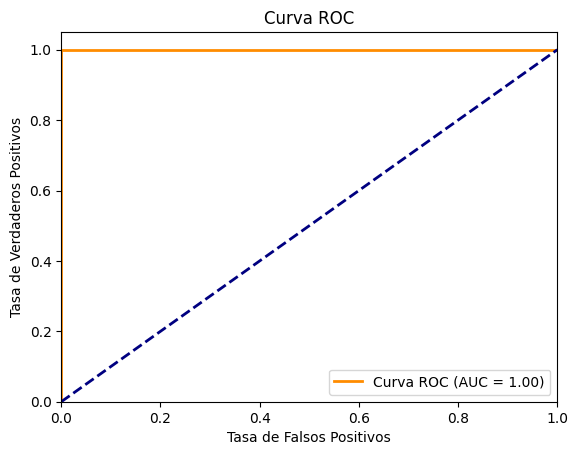

Metrics for Validation set :
 - Accuracy: 0.9451
 - Precision: 0.9452
 - Recall: 0.9451
 - F1-Score: 0.9450
 - Adjusted Rand Index: 0.7917
 - Mean Squared Error: 0.0549
 - R-squared: 0.7794
 - Área bajo la curva : 0.944
 - Confusion Matrix: 
[[159  12]
 [  8 185]]
 - Global Score : 92.67



C:\Users\danie\AppData\Local\Temp\ipykernel_12012\2767002191.py:270: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)


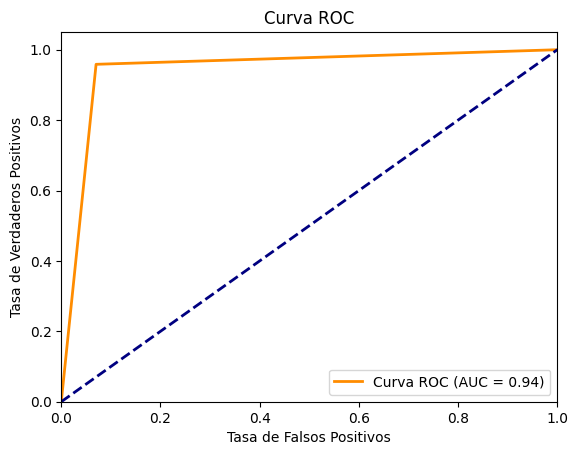

Metrics for Test set :
 - Accuracy: 0.9313
 - Precision: 0.9313
 - Recall: 0.9313
 - F1-Score: 0.9313
 - Adjusted Rand Index: 0.7434
 - Mean Squared Error: 0.0687
 - R-squared: 0.7231
 - Área bajo la curva : 0.931
 - Confusion Matrix: 
[[153  13]
 [ 12 186]]
 - Global Score : 90.88



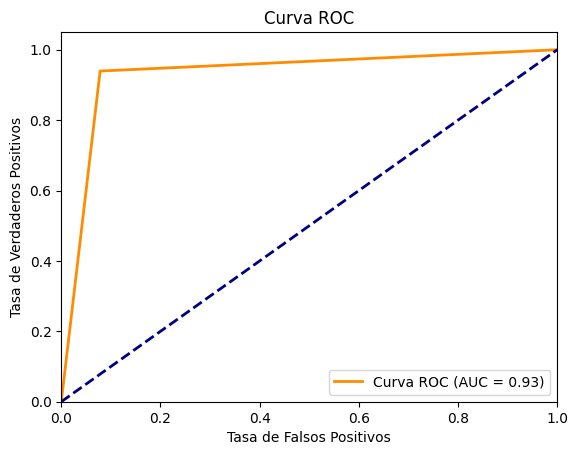

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Gradient Boosting,Training,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,475,0,0,614,100.00
1,Gradient Boosting,Validation,0.945055,0.945198,0.945055,0.945012,0.791723,0.054945,0.779414,0.944187,159,12,8,185,92.67
2,Gradient Boosting,Test,0.931319,0.931298,0.931319,0.931301,0.743431,0.068681,0.723135,0.930540,153,13,12,186,90.88


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

model_name = "Gradient Boosting"
print(model_name)

# Configurar la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.07, 0.10, 0.5, 1.0],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Inicializar el modelo AdaBoost
GradBoost = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, random_state=42)

grid_search = GridSearchCV(estimator=GradBoost, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Mejor modelo
best_model = grid_search.best_estimator_

# Cross validation
mostrar_cross_validation(best_model, X_train_prep, y_train)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
best_model.fit(X_train_prep, y_train)

y_train_pred = best_model.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "SI")

y_pred = best_model.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla(y_val, y_pred, "Validation",model_name, print_roc = "SI")

y_test_pred = best_model.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "SI")


## Redes Neuronales Artificiales

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Crear una instancia del modelo de regresión lineal
model_ANN = tf.keras.models.Sequential()
model_name = "Artificial Network Layers (ANN)"
print(model_name)

def create_model(optimizer='adam', init_mode='uniform', activation='relu', dropout_rate=0.0, neurons=1):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Crear el modelo KerasClassifier con parámetros por defecto
model = KerasClassifier(model=create_model, verbose=0)

# Definir el grid de hiperparámetros a buscar
param_grid = {
    'model__optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'lecun_uniform', 'normal'],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__dropout_rate': [0.0, 0.1, 0.2],
    'model__neurons': [5, 10, 15],
    'batch_size': [10, 20, 40],
    'epochs': [50, 100, 150],
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=10,  # Número de combinaciones a probar
                                   cv=3,  # Número de folds para la validación cruzada
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Entrenar el modelo usando RandomizedSearchCV
random_search.fit(X_train_prep, y_train)

# Obtener los mejores parámetros encontrados
best_params = random_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Evaluar el mejor modelo en el conjunto de prueba
model_ANN = random_search.best_estimator_

model_ANN.fit(X_train_prep, y_train, batch_size=32, epochs=50)

# Predecir en los conjuntos de datos
y_train_pred = model_ANN.predict(X_train_prep)
y_val_pred = model_ANN.predict(X_val_prep)
y_test_pred = model_ANN.predict(X_test_prep)

# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")



Artificial Network Layers (ANN)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros encontrados: {'model__optimizer': 'Adam', 'model__neurons': 5, 'model__init_mode': 'normal', 'model__dropout_rate': 0.0, 'model__activation': 'sigmoid', 'epochs': 50, 'batch_size': 10}
Metrics for Training set :
 - Accuracy: 0.8118
 - Precision: 0.8297
 - Recall: 0.8118
 - F1-Score: 0.8122
 - Adjusted Rand Index: 0.3882
 - Mean Squared Error: 0.1882
 - R-squared: 0.2345
 - Área bajo la curva : 0.822
 - Confusion Matrix: 
[[428  47]
 [158 456]]
 - Global Score : 76.51

Metrics for Validation set :
 - Accuracy: 0.8159
 - Precision: 0.8246
 - Recall: 0.8159
 - F1-Score: 0.8157
 - Adjusted Rand Index: 0.3976
 - Mean Squared Error: 0.1841
 - R-squared: 0.2610
 - Área bajo la curva : 0.820
 - Confusion Matrix: 
[[151  20]
 [ 47 146]]
 - Global Score : 76.71

Metrics for Test set :
 - Accuracy: 0.8077
 - Precision: 0.8323
 - Recall: 0.8077
 - F1-Score: 0.8068
 - Adjusted Rand Index:

,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Random Forest,Training,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,475,0,0,614,100.00
1,Random Forest,Validation,0.876374,0.879788,0.876374,0.875637,0.565425,0.123626,0.503681,0.872754,139,32,13,180,83.82
2,Random Forest,Test,0.895604,0.895972,0.895604,0.895349,0.624954,0.104396,0.579165,0.892844,143,23,15,183,86.24
3,LDA,Training,0.813590,0.822818,0.813590,0.814348,0.392806,0.186410,0.242013,0.819439,411,64,139,475,76.50
4,LDA,Validation,0.788462,0.789031,0.788462,0.788598,0.331003,0.211538,0.150744,0.788519,135,36,41,152,73.22
5,LDA,Test,0.895604,0.895972,0.895604,0.895349,0.624954,0.104396,0.579165,0.892844,143,23,15,183,86.24
6,LDA,Training,0.813590,0.822818,0.813590,0.814348,0.392806,0.186410,0.242013,0.819439,411,64,139,475,76.50
7,LDA,Validation,0.788462,0.789031,0.788462,0.788598,0.331003,0.211538,0.150744,0.788519,135,36,41,152,73.22
8,LDA,Test,0.807692,0.815287,0.807692,0.807971,0.376989,0.192308,0.224778,0.812036,143,23,47,151,75.72
9,LDA,Training,0.795225,0.825122,0.795225,0.794968,0.347828,0.204775,0.167334,0.809587,438,37,186,428,74.81


## Máquinas de vectores de soporte de regresión (SVR)

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# TODO + 10 minutos de ejecución -- CORREGIR
# Definir el modelo SVR
model_name = "SVR"
print(model_name)
svr = SVR()

# Definir los hiperparámetros a buscar
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2]
}

''' Tiempo de ejecucion > 13 minutos
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}
'''

# Definir GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_SVR = grid_search.best_estimator_

print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = model_SVR.predict(X_train_prep)
y_val_pred = model_SVR.predict(X_val_prep)
y_test_pred = model_SVR.predict(X_test_prep)

umbral = 0.55

y_train_pred_binary = (y_train_pred >= umbral).astype(int)
y_val_pred_binary = (y_val_pred >= umbral).astype(int)
y_test_pred_binary = (y_test_pred >= umbral).astype(int)

mostrar_estadisticas_guardar_tabla(y_train, y_train_pred_binary, "Training", model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred_binary, "Validation",model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred_binary, "Test", model_name, print_roc = "NO")

SVR
Mejores parámetros {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Metrics for Training set :
 - Accuracy: 0.8338
 - Precision: 0.8439
 - Recall: 0.8338
 - F1-Score: 0.8345
 - Adjusted Rand Index: 0.4452
 - Mean Squared Error: 0.1662
 - R-squared: 0.3242
 - Área bajo la curva : 0.840
 - Confusion Matrix: 
[[424  51]
 [130 484]]
 - Global Score : 78.98

Metrics for Validation set :
 - Accuracy: 0.8242
 - Precision: 0.8269
 - Recall: 0.8242
 - F1-Score: 0.8243
 - Adjusted Rand Index: 0.4188
 - Mean Squared Error: 0.1758
 - R-squared: 0.2941
 - Área bajo la curva : 0.826
 - Confusion Matrix: 
[[146  25]
 [ 39 154]]
 - Global Score : 77.57

Metrics for Test set :
 - Accuracy: 0.8352
 - Precision: 0.8513
 - Recall: 0.8352
 - F1-Score: 0.8350
 - Adjusted Rand Index: 0.4478
 - Mean Squared Error: 0.1648
 - R-squared: 0.3355
 - Área bajo la curva : 0.843
 - Confusion Matrix: 
[[154  12]
 [ 48 150]]
 - Global Score : 79.24



,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,SVR,Training,0.835629,0.840856,0.835629,0.836265,0.450082,0.164371,0.331627,0.839222,412,63,116,498,79.04
1,SVR,Training,0.835629,0.840856,0.835629,0.836265,0.450082,0.164371,0.331627,0.839222,412,63,116,498,79.04
2,SVR,Validation,0.826923,0.826875,0.826923,0.826893,0.425937,0.173077,0.305154,0.826122,139,32,31,162,77.78
3,SVR,Test,0.840659,0.847338,0.840659,0.840924,0.462724,0.159341,0.357673,0.844773,148,18,40,158,79.69
4,SVR,Training,0.810836,0.846565,0.810836,0.810241,0.385647,0.189164,0.230811,0.827005,453,22,184,430,76.79
5,SVR,Validation,0.802198,0.827413,0.802198,0.800325,0.363523,0.197802,0.205890,0.809472,159,12,60,133,75.35
6,SVR,Test,0.791209,0.839830,0.791209,0.787642,0.337148,0.208791,0.158330,0.805647,161,5,71,127,74.52
7,SVR,Training,0.746556,0.825531,0.746556,0.740081,0.241104,0.253444,-0.030564,0.772861,465,10,266,348,70.00
8,SVR,Validation,0.739011,0.810296,0.739011,0.728137,0.226265,0.260989,-0.047784,0.752219,166,5,90,103,68.61
9,SVR,Test,0.706044,0.810539,0.706044,0.689178,0.166587,0.293956,-0.184982,0.728824,164,2,105,93,65.50


## Regresión polinomial

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model_name = "Regresión polinomial"
print(model_name)

# Definir el pipeline para regresión polinomial
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('logistic', LogisticRegression(max_iter=10000))
])

# Definir los hiperparámetros a buscar. Un grado muy alto del polinomio puede llevar a sobreajuste (overfitting)
param_grid = {
    'poly__degree': [2, 3, 4, 5],  # grados del polinomio
    'logistic__C': [0.1, 1, 10, 100],  # regularización
    'logistic__fit_intercept': [True, False]
}

# Definir GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_RPoli = grid_search.best_estimator_

print(f"Mejores parámetros {grid_search.best_params_}")

y_train_pred = model_RPoli.predict(X_train_prep)
y_val_pred = model_RPoli.predict(X_val_prep)
y_test_pred = model_RPoli.predict(X_test_prep)
print(y_train_pred)
# Evaluar el modelo
mostrar_estadisticas_guardar_tabla(y_train, y_train_pred, "Training", model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_val, y_val_pred, "Validation",model_name, print_roc = "NO")
mostrar_estadisticas_guardar_tabla(y_test, y_test_pred, "Test", model_name, print_roc = "NO")


Regresión polinomial
Mejores parámetros {'logistic__C': 1, 'logistic__fit_intercept': True, 'poly__degree': 3}
[0 1 0 ... 1 1 0]
Metrics for Training set :
 - Accuracy: 0.8512
 - Precision: 0.8526
 - Recall: 0.8512
 - F1-Score: 0.8516
 - Adjusted Rand Index: 0.4930
 - Mean Squared Error: 0.1488
 - R-squared: 0.3951
 - Área bajo la curva : 0.851
 - Confusion Matrix: 
[[405  70]
 [ 92 522]]
 - Global Score : 80.8

Metrics for Validation set :
 - Accuracy: 0.8104
 - Precision: 0.8109
 - Recall: 0.8104
 - F1-Score: 0.8099
 - Adjusted Rand Index: 0.3838
 - Mean Squared Error: 0.1896
 - R-squared: 0.2390
 - Área bajo la curva : 0.808
 - Confusion Matrix: 
[[131  40]
 [ 29 164]]
 - Global Score : 75.74

Metrics for Test set :
 - Accuracy: 0.8269
 - Precision: 0.8290
 - Recall: 0.8269
 - F1-Score: 0.8272
 - Adjusted Rand Index: 0.4259
 - Mean Squared Error: 0.1731
 - R-squared: 0.3023
 - Área bajo la curva : 0.828
 - Confusion Matrix: 
[[140  26]
 [ 37 161]]
 - Global Score : 77.88



C:\Users\danie\AppData\Local\Temp\ipykernel_5936\3849515159.py:270: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tabla_results_df = pd.concat([tabla_results_df, new_row], ignore_index=True)


,Model,Set,Accuracy,Precision,Recall,F1-Score,Adjusted Rand Index,Mean Squared Error,R-squared,AUC-ROC,TN,FP,FN,TP,Global Score
0,Regresión polinomial,Training,0.851240,0.852591,0.851240,0.851566,0.492959,0.148760,0.395104,0.851397,405,70,92,522,80.80
1,Regresión polinomial,Validation,0.810440,0.810888,0.810440,0.809916,0.383791,0.189560,0.238978,0.807911,131,40,29,164,75.74
2,Regresión polinomial,Test,0.826923,0.829039,0.826923,0.827226,0.425943,0.173077,0.302300,0.828252,140,26,37,161,77.88


## Borrar informacion tabla

In [83]:
# Borrar todos los registros
tabla_results_df = tabla_results_df.iloc[0:0]
tabla_results_NS_df = tabla_results_NS_df.iloc[0:0]

# Aprendizaje no supervisado

## Clustering jerárquico

In [ ]:

# Crear una instancia del modelo de clustering jerárquico
from sklearn.cluster import AgglomerativeClustering

model_AC = AgglomerativeClustering(n_clusters=2)

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_AC.fit(X_train_prep)

# Predecir en el conjunto de validación
y_pred = model_AC.fit_predict(X_val_prep)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)

# Calcular la precisión
precision = precision_score(y_val, y_pred)

# Calcular la exhaustividad
recall = recall_score(y_val, y_pred)

# Calcular la puntuación F1
f1 = f1_score(y_val, y_pred)

print("Matriz de Confusión :\n", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



## Clustering K-means

In [16]:
from sklearn.cluster import KMeans
model_name = 'KMeans'
print(model_name)
model_KM = KMeans(random_state=42)

# Obtención del número de clusters optimo, escoger entre elbow o silhouette
optimal_k = optimal_cluster_number(X_train_prep, X_val_prep, model_KM, method='silhouette')
print("Número óptimo de clusters según el método del codo:", optimal_k)

# Ajustar el modelo con el número óptimo de clusters
model_KM.n_clusters = optimal_k

# Entrenar el modelo usando los datos de entrenamiento preprocesados
model_KM.fit(X_train_prep)

labels_train = model_KM.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = model_KM.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = model_KM.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

KMeans
Número óptimo de clusters según el método del codo: 2
Metrics for Training set (KMeans):
 - Silhouette Score: 0.5892
 - Davies-Bouldin Index: 1.6353
 - Calinski-Harabasz Index: 215.7722
 - Global Score: 87.8223

Metrics for Validation set (KMeans):
 - Silhouette Score: 0.6177
 - Davies-Bouldin Index: 1.7655
 - Calinski-Harabasz Index: 65.4537
 - Global Score: 36.0215

Metrics for Test set (KMeans):
 - Silhouette Score: 0.6531
 - Davies-Bouldin Index: 1.4111
 - Calinski-Harabasz Index: 112.5643
 - Global Score: 58.2229



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.589238,1.635342,215.772165,87.822329
1,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
2,KMeans,Test,0.653144,1.411056,112.564337,58.222912
3,KMeans,Entrenamiento,0.427582,1.065326,215.248011,93.364851
4,KMeans,Evaluación,0.512824,1.149159,72.724670,44.483306
5,KMeans,Test,0.492667,0.975618,140.325935,72.465829
6,Mean Shift,Training,0.458234,0.573478,114.974797,76.846230
7,KMeans,Training,0.589238,1.635342,215.772165,87.822329
8,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
9,KMeans,Test,0.653144,1.411056,112.564337,58.222912


In [14]:
''' Pruebas K-means 
La función encontrar_numero_optimo_clusters es algo más compleja y puede que ayude a ajustar mejor el modelo K-means
Utiliza la predicción con los datos de validación para establecer las métricas para cada valor de cluster (0-10).
Con ello, toma una decisión final donde el global_score sea máximo
# establece qué número de clusteres es el más correcto, en un tiempo decente de en entorno a 1 min
'''
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model_name = 'KMeans'
print(model_name)
model_KM = KMeans(random_state=42)

# Encontrar el número óptimo de clústeres
num_clusters_optimo = encontrar_numero_optimo_clusters(X_train_prep, X_val_prep, model_KM, plot_grafica = 'NO')
print("Número de clusteres optimo : " + str(num_clusters_optimo))
# Entrenar el modelo final con el número óptimo de clústeres usando los datos de entrenamiento
kmeans_final = KMeans(n_clusters=num_clusters_optimo, random_state=0)
kmeans_final.fit(X_train_prep)
labels_train = model_KM.predict(X_train_prep)
show_save_results_no_supervised(X_train_prep, labels_train, 'Entrenamiento',  model_name)

# Evaluar el modelo en los datos de evaluación
labels_val = kmeans_final.predict(X_val_prep)
show_save_results_no_supervised(X_val_prep, labels_val,'Evaluación', model_name)

labels_test = kmeans_final.predict(X_test_prep)
show_save_results_no_supervised(X_test_prep, labels_test,'Test', model_name)



KMeans
Número de clusteres optimo : 7
Metrics for Entrenamiento set (KMeans):
 - Silhouette Score: 0.4276
 - Davies-Bouldin Index: 1.0653
 - Calinski-Harabasz Index: 215.2480
 - Global Score: 93.3649

Metrics for Evaluación set (KMeans):
 - Silhouette Score: 0.5128
 - Davies-Bouldin Index: 1.1492
 - Calinski-Harabasz Index: 72.7247
 - Global Score: 44.4833

Metrics for Test set (KMeans):
 - Silhouette Score: 0.4927
 - Davies-Bouldin Index: 0.9756
 - Calinski-Harabasz Index: 140.3259
 - Global Score: 72.4658



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.589238,1.635342,215.772165,87.822329
1,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
2,KMeans,Test,0.653144,1.411056,112.564337,58.222912
3,KMeans,Entrenamiento,0.427582,1.065326,215.248011,93.364851
4,KMeans,Evaluación,0.512824,1.149159,72.724670,44.483306
5,KMeans,Test,0.492667,0.975618,140.325935,72.465829


## Mean Shift

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

model_name = 'Mean Shift'
print(model_name)

# Función para realizar la búsqueda de bandwidth óptimo
def find_optimal_bandwidth(X, bandwidths):
    best_bandwidth = None
    best_score = -1
    best_labels = None
    best_cluster_centers = None
    
    for bandwidth in bandwidths:
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(X)
        labels = ms.labels_
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_bandwidth = bandwidth
                best_labels = labels
                best_cluster_centers = ms.cluster_centers_
    
    return best_bandwidth, best_labels, best_cluster_centers, best_score

# Definir el rango de valores de bandwidth para la búsqueda
bandwidths = np.linspace(0.1, 2.0, 20)

# Buscar el bandwidth óptimo usando el conjunto de validación
optimal_bandwidth, labels_val, cluster_centers, best_score = find_optimal_bandwidth(X_val_prep, bandwidths)

print("Bandwidth óptimo:", optimal_bandwidth)
print("Mejor Silhouette Score en Validación:", best_score)
print("Número de clústeres estimados en Validación:", len(np.unique(labels_val)))

def map_clusters_to_labels(labels, true_labels):
    from scipy.stats import mode
    # Asegurarse de que labels y true_labels sean arreglos
    labels = np.asarray(labels)
    true_labels = np.asarray(true_labels)
    
    # Crear una matriz de confusión
    conf_matrix = confusion_matrix(true_labels, labels)
    
    # Crear un arreglo para mapear los clusters a las etiquetas reales
    cluster_label_map = np.zeros_like(labels)
    
    # Asignar la etiqueta de clase más frecuente a cada cluster
    for i in range(conf_matrix.shape[1]):
        mask = labels == i
        if np.any(mask):  # Asegurarse de que el cluster tenga etiquetas
            most_common_label = mode(true_labels[mask])[0][0]
            cluster_label_map[mask] = most_common_label
    
    return cluster_label_map

# Entrenar el modelo final en el conjunto de entrenamiento usando el bandwidth óptimo
ms = MeanShift(bandwidth=optimal_bandwidth, bin_seeding=True)
ms.fit(X_train_prep)
labels_train = ms.labels_

labels_train = ms.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = ms.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = ms.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Mean Shift


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\cluster\_mean_shift.py:293: UserWarning: Binning data failed with provided bin_size=0.100000, using data points as seeds.
  warnings.warn(


Bandwidth óptimo: 2.0
Mejor Silhouette Score en Validación: 0.49431989853400954
Número de clústeres estimados en Validación: 24
Metrics for Training set (Mean Shift):
 - Silhouette Score: 0.4582
 - Davies-Bouldin Index: 0.5735
 - Calinski-Harabasz Index: 114.9748
 - Global Score: 69.7375

Metrics for Validation set (Mean Shift):
 - Silhouette Score: 0.4821
 - Davies-Bouldin Index: 0.6987
 - Calinski-Harabasz Index: 74.6950
 - Global Score: 54.6217

Metrics for Test set (Mean Shift):
 - Silhouette Score: 0.4413
 - Davies-Bouldin Index: 0.8014
 - Calinski-Harabasz Index: 68.3151
 - Global Score: 50.1032



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.589238,1.635342,215.772165,87.822329
1,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
2,KMeans,Test,0.653144,1.411056,112.564337,58.222912
3,KMeans,Entrenamiento,0.427582,1.065326,215.248011,93.364851
4,KMeans,Evaluación,0.512824,1.149159,72.724670,44.483306
5,KMeans,Test,0.492667,0.975618,140.325935,72.465829
6,Mean Shift,Training,0.458234,0.573478,114.974797,76.846230
7,KMeans,Training,0.589238,1.635342,215.772165,87.822329
8,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
9,KMeans,Test,0.653144,1.411056,112.564337,58.222912


## Clustering DBSCAN

In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model_name = 'DBSCAN'
print(model_name)

# Función para encontrar el mejor valor de eps
def find_optimal_eps(X, eps_values, min_samples):
    best_eps = None
    best_score = -1
    best_labels = None
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Solo evaluar si hay más de un cluster (ignorar ruido)
        if len(np.unique(labels)) > 1 and np.sum(labels != -1) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_labels = labels
                
    return best_eps, best_labels, best_score

# Definir el rango de valores de eps para la búsqueda
eps_values = np.linspace(0.1, 5.0, 50)
min_samples = 5  # Puedes ajustar este valor según sea necesario

# Buscar el eps óptimo usando el conjunto de entrenamiento
optimal_eps, labels_train, best_score = find_optimal_eps(X_train_prep, eps_values, min_samples)

print("Epsilon óptimo:", optimal_eps)
print("Mejor Silhouette Score en Entrenamiento:", best_score)
print("Número de clústeres estimados en Entrenamiento:", len(np.unique(labels_train)))

# Entrenar el modelo final en el conjunto de entrenamiento usando el eps óptimo
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=min_samples)

labels_train = dbscan_final.fit_predict(X_train_prep)
labels_val = dbscan_final.fit_predict(X_val_prep)
labels_test = dbscan_final.fit_predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

DBSCAN
Epsilon óptimo: 4.8
Mejor Silhouette Score en Entrenamiento: 0.8349455307521673
Número de clústeres estimados en Entrenamiento: 2
Metrics for Training set (DBSCAN):
 - Silhouette Score: 0.8349
 - Davies-Bouldin Index: 1.7217
 - Calinski-Harabasz Index: 170.5236
 - Global Score: 75.3953

Metrics for Validation set (DBSCAN):
 - Silhouette Score: 0.8204
 - Davies-Bouldin Index: 1.6787
 - Calinski-Harabasz Index: 52.0399
 - Global Score: 36.3747

Metrics for Test set (DBSCAN):
 - Silhouette Score: 0.8233
 - Davies-Bouldin Index: 1.1945
 - Calinski-Harabasz Index: 88.5002
 - Global Score: 56.6458



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Random Forest,Training,0.229602,1.740380,115.132563,46.531218
1,Random Forest,Validation,0.210897,1.816310,36.730034,18.819791
2,Random Forest,Test,0.263973,1.729851,47.569378,24.758483
3,DBSCAN,Training,0.834946,1.721699,170.523605,75.395314
4,DBSCAN,Validation,0.820430,1.678743,52.039884,36.374742
5,DBSCAN,Test,0.823251,1.194508,88.500184,56.645778
6,PCA,Training,0.229602,1.740380,115.132563,46.531218
7,PCA,Validation,0.210897,1.816310,36.730034,18.819791
8,PCA,Test,0.263973,1.729851,47.569378,24.758483
9,PCA,Training,0.229602,1.740380,115.132563,46.531218


## Clustering GMM

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define un pipeline que combina un modelo de mezcla gaussiana
pipeline = Pipeline([
    ('gmm', GaussianMixture(random_state=42))
])

# Define la cuadrícula de parámetros para buscar
param_grid = {
    'gmm__n_components': [1, 2, 3, 4, 5],
    'gmm__covariance_type': ['full', 'tied', 'diag', 'spherical']
}

# Crea un objeto GridSearchCV
model_GMM = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')

# Ajusta el objeto GridSearchCV a los datos
model_GMM.fit(X_train_prep, y_train)

# Imprime los mejores parámetros
print("Mejores parámetros: ", model_GMM.best_params_)


labels_train = model_GMM.predict(X_train_prep)
mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)

labels_val = model_GMM.predict(X_val_prep)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)

labels_test = model_GMM.predict(X_test_prep)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)


Mejores parámetros:  {'gmm__covariance_type': 'spherical', 'gmm__n_components': 2}
Metrics for Training set (Mean Shift):
 - Silhouette Score: 0.4229
 - Davies-Bouldin Index: 1.7908
 - Calinski-Harabasz Index: 157.8364
 - Global Score: 63.1478

Metrics for Validation set (Mean Shift):
 - Silhouette Score: 0.4492
 - Davies-Bouldin Index: 1.8741
 - Calinski-Harabasz Index: 54.3106
 - Global Score: 27.6885

Metrics for Test set (Mean Shift):
 - Silhouette Score: 0.4781
 - Davies-Bouldin Index: 1.7677
 - Calinski-Harabasz Index: 66.4847
 - Global Score: 34.0007



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,KMeans,Training,0.589238,1.635342,215.772165,87.822329
1,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
2,KMeans,Test,0.653144,1.411056,112.564337,58.222912
3,KMeans,Entrenamiento,0.427582,1.065326,215.248011,93.364851
4,KMeans,Evaluación,0.512824,1.149159,72.724670,44.483306
5,KMeans,Test,0.492667,0.975618,140.325935,72.465829
6,Mean Shift,Training,0.458234,0.573478,114.974797,76.846230
7,KMeans,Training,0.589238,1.635342,215.772165,87.822329
8,KMeans,Validation,0.617695,1.765477,65.453656,36.021524
9,KMeans,Test,0.653144,1.411056,112.564337,58.222912


In [ ]:
# Pasar a formato excel 
tabla_results_df.to_excel('model_results.xlsx', index=False)
tabla_results_NS_df.to_excel('model_results_NS.xlsx', index=False)

## Análisis de componentes principales (PCA) 

In [20]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Crear y ajustar el modelo PCA para calcular la variancia explicada
pca_temp = PCA()
pca_temp.fit(X_train_prep)

# Calcular la variancia explicada acumulada
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)

# Determinar el número de componentes que explican al menos el 95% de la variancia
n_components = np.argmax(explained_variance >= 0.95) + 1

if n_components == X_train_prep.shape[1] :
    print(f"Número óptimo de componentes para explicar al menos el 95% de la variancia es de {n_components}" 
      f" que coincide con el número actual de variables es de {X_train_prep.shape[1]}. \n"
       "Por tanto no se aplica el algoritmo PCA")
    
else :
    print(f"Número óptimo de componentes para explicar al menos el 95% de la variancia: {n_components} ")

    # Crear y ajustar el modelo PCA con el número óptimo de componentes
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_prep)
    X_val_pca = pca.transform(X_val_prep)
    X_test_pca = pca.transform(X_test_prep)


Número óptimo de componentes para explicar al menos el 95% de la variancia es de 9 que coincide con el número actual de variables es de 9. 
Por tanto no se aplica el algoritmo PCA


## Análisis discriminante lineal (LDA)

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

model_name = 'LDA'
print(model_name)

lda = LinearDiscriminantAnalysis()

n_features = X_train_prep.shape[1]
n_classes = len(np.unique(y_train))
max_components = min(n_features, n_classes - 1)

# Definir los hiperparámetros a buscar
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'n_components': [None] + list(range(1, max_components + 1))
}

# Definir GridSearchCV
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo con los datos de entrenamiento y encontrar los mejores hiperparámetros
grid_search.fit(X_train_prep, y_train)

# Obtener el mejor modelo y sus hiperparámetros
model_LDA = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters : {best_params}")

model_LDA.fit(X_train_prep, y_train)

labels_train = model_LDA.predict(X_train_prep)
labels_val = model_LDA.predict(X_val_prep)
labels_test = model_LDA.predict(X_test_prep)

mostrar_estadisticas_guardar_tabla_NS(X_train_prep, labels_train, "Training", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_val_prep, labels_val, "Validation", model_name)
mostrar_estadisticas_guardar_tabla_NS(X_test_prep, labels_test, "Test", model_name)

LDA
Best parameters : {'n_components': None, 'solver': 'svd'}
Metrics for Training set (LDA):
 - Silhouette Score: 0.3091
 - Davies-Bouldin Index: 1.7594
 - Calinski-Harabasz Index: 133.1994
 - Global Score: 53.5623

Metrics for Validation set (LDA):
 - Silhouette Score: 0.2775
 - Davies-Bouldin Index: 1.8459
 - Calinski-Harabasz Index: 41.1149
 - Global Score: 20.8976

Metrics for Test set (LDA):
 - Silhouette Score: 0.3448
 - Davies-Bouldin Index: 1.7564
 - Calinski-Harabasz Index: 53.9366
 - Global Score: 27.7848



,Model,Set,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Global Score
0,Random Forest,Training,0.229602,1.740380,115.132563,46.531218
1,Random Forest,Validation,0.210897,1.816310,36.730034,18.819791
2,Random Forest,Test,0.263973,1.729851,47.569378,24.758483
3,DBSCAN,Training,0.834946,1.721699,170.523605,75.395314
4,DBSCAN,Validation,0.820430,1.678743,52.039884,36.374742
5,DBSCAN,Test,0.823251,1.194508,88.500184,56.645778
6,PCA,Training,0.229602,1.740380,115.132563,46.531218
7,PCA,Validation,0.210897,1.816310,36.730034,18.819791
8,PCA,Test,0.263973,1.729851,47.569378,24.758483
9,PCA,Training,0.229602,1.740380,115.132563,46.531218


# Pruebas

### 4.5.2 Peso de cada variable en la predicción de la variable objetivo

Pesos del estudio original 

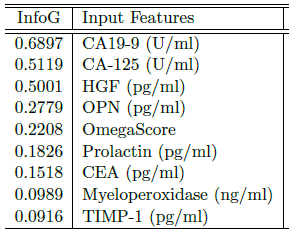

Verificación del "Information Gain" o peso de la variable frente a la variable objetivo a predecir.

#### 4.5.2.1 Método 1 Variables continuas, variable objetivo binaria --> Correlación de Pearson

In [18]:

print("[INFO] Teniendo variables predictivas numéricas continuas y una variable objetivo binaria, se hace uso del coeficiente de correlación de Pearson")
df_numericas = df.select_dtypes(include=['number'])
correlaciones = df_numericas.corrwith(df['Tumor type']).sort_values(ascending=False)

print("\tCorrelación de Pearson : ")
print(correlaciones)

[INFO] Teniendo variables predictivas numéricas continuas y una variable objetivo binaria, se hace uso del coeficiente de correlación de Pearson
	Correlación de Pearson : 
Tumor type                              1.000000
CancerSEEK Logistic Regression Score    0.732341
CancerSEEK Test Result                  0.640972
OPN (pg/ml)                             0.458352
Prolactin (pg/ml)                       0.324378
TIMP-1 (pg/ml)                          0.300539
GDF15 (ng/ml)                           0.247428
HGF (pg/ml)                             0.242512
Myeloperoxidase (ng/ml)                 0.221877
FGF2 (pg/ml)                            0.192212
IL-6 (pg/ml)                            0.186625
Galectin-3 (ng/ml)                      0.180836
Angiopoietin-2 (pg/ml)                  0.170233
OPG (ng/ml)                             0.147721
Omega score                             0.146759
HE4 (pg/ml)                             0.139689
Follistatin (pg/ml)                     0.13

#### 4.5.2.2 Método 2 - Variables discretas (KBinsDiscretizer()), variable objetivo binaria --> Correlación 

In [26]:
# Prueba discretización rápida + correlaciones 
from sklearn.preprocessing import KBinsDiscretizer

df_numericas = df.select_dtypes(include=['number'])
# Inicializar el discretizador basado en cuantiles
discretizer = KBinsDiscretizer(n_bins=12, encode='ordinal', strategy='quantile')

# Discretizar las variables numéricas continuas
df_numericas_discretas = pd.DataFrame(discretizer.fit_transform(df_numericas), columns=df_numericas.columns)

# Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
correlaciones_discretas = df_numericas_discretas.corrwith(df['Tumor type'])

# Ordenar las correlaciones de mayor a menor
correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

# Obtener las top 10 variables numéricas discretas con las correlaciones más altas
top_15_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(15)

# Imprimir las top 10 correlaciones
print(top_15_correlaciones_discretas)

CancerSEEK Logistic Regression Score    0.707618
IL-8 (pg/ml)                            0.577839
OPN (pg/ml)                             0.576522
IL-6 (pg/ml)                            0.475775
GDF15 (ng/ml)                           0.474454
Prolactin (pg/ml)                       0.447670
HGF (pg/ml)                             0.444292
Omega score                             0.379398
Myeloperoxidase (ng/ml)                 0.349025
TGFa (pg/ml)                            0.326160
sEGFR (pg/ml)                           0.320633
TIMP-1 (pg/ml)                          0.301831
CEA (pg/ml)                             0.301361
CA-125 (U/ml)                           0.288792
CA19-9 (U/ml)                           0.275198
dtype: float64


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 42 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


#### 4.5.2.3 Método 3 - Variables discretizado (Arbol de decisión (max_depth = 15)), variable objetivo binaria --> Correlación 

In [48]:
def discretizar_df_arboles(df, max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado

df_discret = discretizar_df_arboles(df.select_dtypes(include=['number']))

# Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
correlaciones_discretas = df_discret.corrwith(df_discret['Tumor type'])

# Ordenar las correlaciones de mayor a menor
correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

# Obtener las top 20 variables numéricas discretas con las correlaciones más altas
top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

# Imprimir las top 20 correlaciones
print(top_20_correlaciones_discretas)

Tumor type                              1.000000
CancerSEEK Logistic Regression Score    0.713090
CancerSEEK Test Result                  0.640972
OPN (pg/ml)                             0.575480
IL-6 (pg/ml)                            0.483620
IL-8 (pg/ml)                            0.464828
HGF (pg/ml)                             0.454991
Prolactin (pg/ml)                       0.453270
Omega score                             0.378112
GDF15 (ng/ml)                           0.365248
CYFRA 21-1 (pg/ml)                      0.356245
Myeloperoxidase (ng/ml)                 0.351481
sEGFR (pg/ml)                           0.319982
CA-125 (U/ml)                           0.312094
CEA (pg/ml)                             0.308045
TIMP-1 (pg/ml)                          0.301340
CA19-9 (U/ml)                           0.266444
Angiopoietin-2 (pg/ml)                  0.233881
HE4 (pg/ml)                             0.232766
Galectin-3 (ng/ml)                      0.232425
dtype: float64


#### 4.5.2.4 Método 4 [PAPER] - Variables discretizado (Random forest (n_estimators=250, criterion='gini') + cross validation), variable objetivo binaria --> Correlación 

In [149]:
# Mismo principio del papear : 5-fold cross-validations are run on the random forests of 250 Gini decision trees for 300 times to give the means and standard deviations as visualized on the error bars.
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Extract features (X) and target variable (y)
X = df.select_dtypes(include=['number']).drop(columns=['Tumor type']).values  # Features
y = df['Tumor type'].values  # Target variable
feature_names = df.select_dtypes(include=['number']).drop(columns=['Tumor type']).columns  # Feature names

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini')

# Train the Random Forest model on the entire dataset
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Step 4: Perform Cross-Validation to get impurity decrease for each fold
cv_scores = []
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train a model on the training data
    rf_classifier.fit(X_train, y_train)
    
    # Get impurity decrease for this fold
    fold_importances = rf_classifier.feature_importances_
    
    # Append impurity decrease to the list
    cv_scores.append(fold_importances)

# Convert list of arrays to a NumPy array
cv_scores = np.array(cv_scores)

# Calculate mean of feature importances for each feature
mean_feature_importances = np.mean(cv_scores, axis=0)

# Combine feature names and mean importances
feature_importance_pairs = list(zip(feature_names, mean_feature_importances))

# Sort features by mean importance (highest to lowest)
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display feature names and their corresponding importances
for feature, importance in sorted_feature_importance_pairs:
    print(f"{feature}: {importance}")

CancerSEEK Logistic Regression Score: 0.16011521821126884
CancerSEEK Test Result: 0.10032455550714223
IL-8 (pg/ml): 0.0892343245533053
IL-6 (pg/ml): 0.06832820072008074
OPN (pg/ml): 0.059120792139012876
HGF (pg/ml): 0.04190430644931378
CYFRA 21-1 (pg/ml): 0.0389622350146014
GDF15 (ng/ml): 0.03771616270368018
Prolactin (pg/ml): 0.036723660119006796
TGFa (pg/ml): 0.03509116397981573
NSE (ng/ml): 0.02216511811777052
CA19-9 (U/ml): 0.022153042393356474
CA-125 (U/ml): 0.02127492298345869
HE4 (pg/ml): 0.019285642050482516
sFas (pg/ml): 0.016896473234596154
Thrombospondin-2 (pg/ml): 0.0157848630570856
Omega score: 0.01566884911588872
sEGFR (pg/ml): 0.014660936558307091
DKK1 (ng/ml): 0.01417835809212938
OPG (ng/ml): 0.010820906632388997
G-CSF (pg/ml): 0.010785879153216858
CD44 (ng/ml): 0.010611486937910457
Myeloperoxidase (ng/ml): 0.009729251590072008
sHER2/sEGFR2/sErbB2 (pg/ml): 0.009612473421891617
AFP (pg/ml): 0.008814860854754043
TIMP-1 (pg/ml): 0.008517105026723216
CEA (pg/ml): 0.00821237

#### 4.5.2.5 Métodos de prueba --> Discretizar uniformemente y por percentiles

In [66]:
def discretizar_frecuencia_uniforme(data, num_bins):
    bins = pd.cut(data, bins=num_bins, labels=False)
    return bins

def discretizar_percentiles(data, num_bins):
    bins = pd.qcut(data, q=num_bins, labels=False, duplicates='drop')
    return bins
def discretizar_uniforme_prueba_1(df):
    df_discretizado_prueba1 = pd.DataFrame()
    for columna in df.select_dtypes(include=['number']).columns:
            if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
                num_bins = int(1 + np.log2(len(df[columna])) + np.log2(np.std(df[columna])))
                print(f" Feature : {columna}, número de bins : {num_bins}")
                df_discretizado_prueba1[columna] = discretizar_frecuencia_uniforme(df[columna], num_bins)
            else:
                # Si la columna no es numérica, simplemente copiarla al dataframe resultante
                df_discretizado_prueba1[columna] = df[columna]

    # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas_p1 = df_discretizado_prueba1.corrwith(df_discretizado_prueba1['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas_p1 = correlaciones_discretas_p1.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas_p1 = correlaciones_discretas_ordenadas_p1.nlargest(20)

    # Imprimir las top 20 correlaciones
    print(top_20_correlaciones_discretas_p1)

# ------------------------------------------------------------

def discretizar_percentiles_prueba_1(df):
    df_discretizado_prueba1 = pd.DataFrame()
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc': # Comprueba si el tipo de datos de la columna es numérico
            num_bins = int(1 + np.log2(len(df[columna])) + np.log2(np.std(df[columna])))

            # Verificar si hay NaNs en los datos originales
            if df[columna].isnull().any():
                print(f"Advertencia: La columna '{columna}' contiene valores NaN.")

            # Discretizar solo si no hay NaNs en los datos originales
            if not df[columna].isnull().any():
                df_discretizado_prueba1[columna] = discretizar_percentiles(df[columna], num_bins)
                print(f"Feature : {columna}, número de bins : {num_bins}")

        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado_prueba1[columna] = df[columna]

    print(df_discretizado_prueba1.head(10))

    # Verificar si hay NaNs en los datos discretizados
    if df_discretizado_prueba1.isnull().any().any():
        print("Advertencia: Se han generado valores NaN durante la discretización.")

    # Calcular el coeficiente de correlación solo si no hay NaNs en los datos discretizados
    if not df_discretizado_prueba1.isnull().any().any():
        correlaciones_discretas_p1 = df_discretizado_prueba1.corrwith(df_discretizado_prueba1['Tumor type'])

        # Ordenar las correlaciones de mayor a menor
        correlaciones_discretas_ordenadas_p1 = correlaciones_discretas_p1.abs().sort_values(ascending=False)

        # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
        top_20_correlaciones_discretas_p1 = correlaciones_discretas_ordenadas_p1.nlargest(20)

        # Imprimir las top 20 correlaciones
        print(top_20_correlaciones_discretas_p1)

In [ ]:
discretizar_uniforme_prueba_1(df)

In [ ]:
# No funciona, muestra todas las corelaciones como NaN
discretizar_percentiles_prueba_1(df)

### 4.5.3 Comparación de resultados de information gain

- Método 1 - Variables continuas, variable objetivo binaria --> Correlación de Pearson
- Método 2 - Variables discretas (KBinsDiscretizer()), variable objetivo binaria --> Correlación 
- Método 3 - Variables discretizado (Arbol de decisión (max_depth = 15)), variable objetivo binaria --> Correlación

 ------------- Método 1 ---------------------------------- Método 2 --------------------------- Método 3 -----------

|Variable|Valor|Variable|Valor|Variable|Valor|
|------------------------|--------------|-----------|-----------|--------------|------------|
| OPN (pg/ml)          |                 0.458352 | IL-8 (pg/ml)                 |           0.578037 |OPN (pg/ml)                  |         0.575480
Prolactin (pg/ml)       |                0.324378 | OPN (pg/ml)                   |          0.571791 |IL-6 (pg/ml)                  |           0.483620
TIMP-1 (pg/ml)          |                0.300539 | IL-6 (pg/ml)                  |          0.480112 |IL-8 (pg/ml)                  |          0.464828
GDF15 (ng/ml)           |                0.247428 | GDF15 (ng/ml)                 |          0.474477 |HGF (pg/ml)                |          0.454991
HGF (pg/ml)              |               0.242512 | Prolactin (pg/ml)              |         0.452567 |Prolactin (pg/ml)              |         0.453270
Myeloperoxidase (ng/ml)  |               0.221877 | HGF (pg/ml)                   |          0.447965 |Omega score                    |        0.378112
FGF2 (pg/ml)              |              0.192212 | Omega score                   |          0.363410 |GDF15 (ng/ml)                   |         0.365248
IL-6 (pg/ml)              |              0.186625 | Myeloperoxidase (ng/ml)       |          0.344990 |CYFRA 21-1 (pg/ml)         |         0.356245
Galectin-3 (ng/ml)        |              0.180836 | sEGFR (pg/ml)                 |          0.320824 |Myeloperoxidase (ng/ml)                 |          0.351481
Angiopoietin-2 (pg/ml)     |             0.170233 | CA19-9 (U/ml)                 |          0.311742 |sEGFR (pg/ml)                   |        0.319982
OPG (ng/ml)                |             0.147721 | TGFa (pg/ml)                   |         0.302511 |CA-125 (U/ml)                  |          0.312094
Omega score                |             0.146759 | TIMP-1 (pg/ml)                |          0.302504 |CEA (pg/ml)                |            0.308045
HE4 (pg/ml)                 |            0.139689 | CEA (pg/ml)                    |         0.300193 |TIMP-1 (pg/ml)                  |          0.301340
Follistatin (pg/ml)         |            0.137546 | CA-125 (U/ml)                 |         0.295434  |CA19-9 (U/ml)               |          0.266444
CEA (pg/ml)                 |            0.126718 | | | Angiopoietin-2 (pg/ml) |0.233881

PAPER : "Contrary to the information gain ranking on Table S1, the cancer
antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the
purity and accuracy measurements; such a phenomenon exemplifies the underlying complex behavior for
cancer detection"

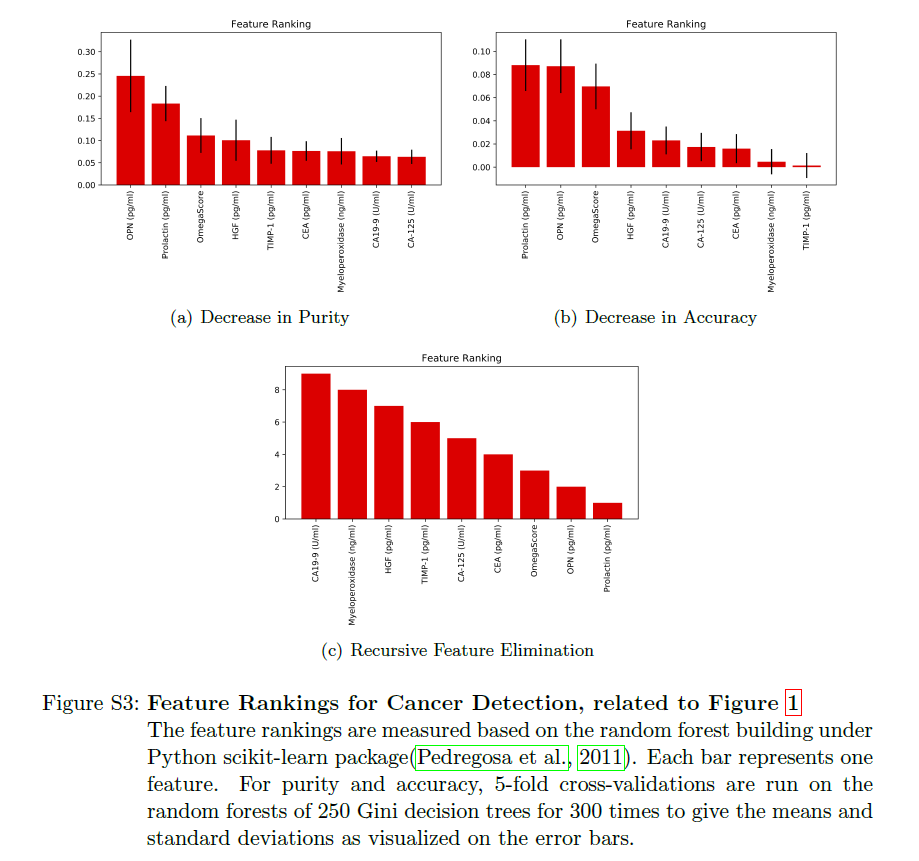